### 权重衰减

#### 权重衰减等价于L2范数正则化。正则化通过为损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段。带有L2范数惩罚项的新损失函数为l(w,b)+λ/2||w||^2,其中λ>0。权重衰减通过惩罚绝对值较大的模型参数为需要学习的模型增加了限制，这可能对过拟合有效。实际场中，有时也添加偏差元素的平方和。

##### 高维线性回归实验

In [2]:
%matplotlib inline
from mxnet import gluon, nd, autograd, init
from mxnet.gluon import loss as gloss, nn, data as gdata
import d2lzh as d2l

n_train, n_test, num_inputs = 20, 100, 200
features = nd.random.normal(shape=(n_train+n_test, num_inputs))
true_w, true_b = nd.zeros(shape=(num_inputs, 1))*0.01, 0.05
labels = nd.dot(features, true_w)+true_b
labels += nd.random.normal(scale = 0.01, shape=labels.shape)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

In [3]:
true_w.shape, nd.dot(features, true_w).shape

((200, 1), (120, 1))

### 从零开始实现

#### 初始化模型参数

In [45]:
def init_params():
    w = nd.random.normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    w.attach_grad()
    b.attach_grad()
    return [w, b]

#### 定义L2范数惩罚项

In [8]:
def l2_penalty(w):
    return (w**2).sum()/2

#### 定义训练和测试

In [51]:
batch_size, num_epochs, lr = 5, 100, 0.03
net, loss = d2l.linreg, d2l.squared_loss
train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels),
                             batch_size = batch_size, shuffle = True)

def fit_and_plot(lambd):
    train_ls, test_ls = [], []
    w, b = init_params()
    w_norm = []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X, w, b), y)+lambd*l2_penalty(w)
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().asscalar())
        w_norm.append(w.norm().asscalar())
    d2l.semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'loss', 
                range(1, num_epochs+1), test_ls, ['train', 'test'])
    d2l.semilogy(range(1, num_epochs+1), w_norm, 'epochs', 'L2 norm of w')
    print('L2 norm of w:', w.norm().asscalar())

#### 观察过拟合。当lambd为0时，没有使用权重衰减，训练集上的误差应远小于测试集上的误差。

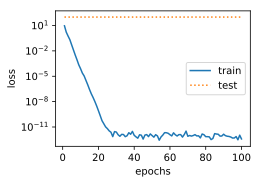

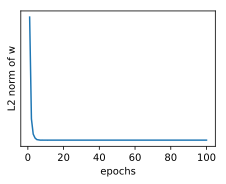

L2 norm of w: 13.683592


In [52]:
fit_and_plot(lambd=0)

#### 使用权重衰减。当lambd=3时，测试集上的误差应有所下降，过拟合现象得到一定程度的缓解。另外权重参数的L2范数应比不使用权重衰减时的更小，更接近0

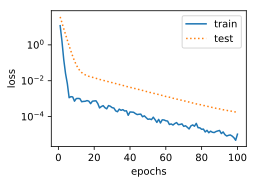

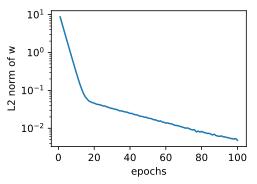

L2 norm of w: 0.0048264284


In [48]:
fit_and_plot(lambd=3)

### 简洁实现

#### 在构造Trainer实例时，可以通过wd参数来指定权重衰减超参数。默认下，Gluon会对权重和偏差同时衰减。可以分别对权重和偏差构造Trainer实例，从而只对权重衰减。

In [59]:
def fit_and_plot_gluon(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    # 对权重参数衰减。权重名称一般是以weight结尾
    trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd', 
                             {'learning_rate':lr,'wd':wd})
    # 不对偏差参数衰减。偏差名称一般是以bias结尾
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd',
                             {'learning_rate':lr})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
        train_ls.append((loss(net(train_features), train_labels)).mean().asscalar())
        test_ls.append((loss(net(test_features), test_labels)).mean().asscalar())
    d2l.semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'loss',
                range(1, num_epochs+1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net[0].weight.data().norm().asscalar())

#### 与从零开始实现权重衰减的实验现类似，使用权重衰减可以在一定程度上缓解过拟合

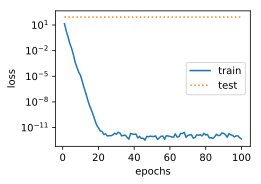

L2 norm of w: 13.395039


In [60]:
fit_and_plot_gluon(0)

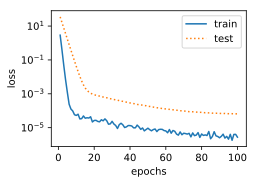

L2 norm of w: 0.0030889509


In [61]:
fit_and_plot_gluon(3)

### 小结

#### 在实验的过程中，期初按照教程，把batch_size的值设为1，绘制出的loss呈上升趋势，而非减小。之后通过把batch_size的值设置为更大的值，绘制出的图才和教程中的图走势相同。